In [1]:
import sys
!{sys.executable} -m pip install --upgrade numpy
!{sys.executable} -m pip install plotly pandas
!{sys.executable} -m pip install -vvv --no-cache-dir git+https://github.com/florianwechsung/PyPlasmaOpt@fw/riskaverse

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.1)
Created temporary directory: /tmp/pip-ephem-wheel-cache-aa3ng6i4
Created temporary directory: /tmp/pip-req-tracker-kcim_8sy
Created requirements tracker '/tmp/pip-req-tracker-kcim_8sy'
Created temporary directory: /tmp/pip-install-g48fcjk6
  Created temporary directory: /tmp/pip-req-build-ybk6g0wk
  Cloning https://github.com/florianwechsung/PyPlasmaOpt (to revision fw/riskaverse) to /tmp/pip-req-build-ybk6g0wk
  Running command git clone -q https://github.com/florianwechsung/PyPlasmaOpt /tmp/pip-req-build-ybk6g0wk
  Running command git show-ref fw/riskaverse
  af785b73f64dc602773fff39514ec205f16c0990 refs/remotes/origin/fw/riskaverse
  Running command git symbolic-ref -q HEAD
  refs/heads/master
  Running command git checkout -b fw/riskaverse --track origin/fw/riskaverse
  Switched to a new branch 'fw/riskaverse'
  Branch 'fw/riskaverse' set up to track remote branch 'fw/riskaverse' from 'origin'.

In [2]:
from pyplasmaopt import *
import logging
logging.getLogger('PyPlasmaOpt').setLevel(40)

## Magnetic axis optimization

Assuming stellarator symmetry, the expansion axis in cylindrical coordinates $\Gamma = (R,\phi,Z)$ is written as a Fourier series, e.g. 

\begin{align}
R(\phi) &= c_{0,R} + \sum_{k = 1}^{N_f} c_{k,R} \cos(2\pi k \phi), \\
Z(\phi) &= \sum_{k = 1}^{N_f} s_{k,Z} \sin(2\pi k \phi),
\end{align}
where $\phi \in[0,1)$.  The $y$ and $z$ components of the curves are similarly defined.

To illustrate this, let's an expansion axis.  Here, $N_f = 3$.

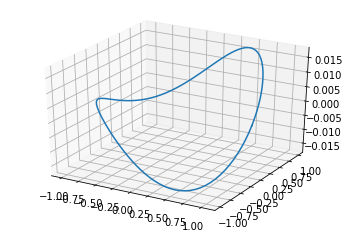

In [3]:
nf = 3
nphi = 100
axis = StelleratorSymmetricCylindricalFourierCurve(nf, 1, np.linspace(0, 1, nphi, endpoint=False))

# The Fourier coefficients in axis.coefficients are organized as follows
# coeffs = [ [c_{0,R}, c_{1,R}, c_{2,R}, c_{3,R}],
#            [s_{1,z}, s_{2,z}, s_{3,z}]
#          ]
axis.coefficients[0][0] = 1.
axis.coefficients[0][1] = 0.02
axis.coefficients[0][2] = 0.02
axis.coefficients[0][3] = 0.0

axis.coefficients[1][0] = .01
axis.coefficients[1][1] = .01
axis.coefficients[1][2] =  .0
axis.update()
axis.plot()

## Task 1

Modify the Fourier coefficients in `axis` above to obtain a flat axis centered at the origin with radius 1, contained in the $xy$ plane.

# Let's compute the length of the axis

The length of the axis is given by
$$
L = \int^{1}_{0} ||\Gamma'(\phi)||_2 d\phi.
$$
where $||\Gamma'(\phi)||_2$ is the norm of the coil tangent.
We can compute the length by discretizing the above using the trapezoidal rule.  
The length becomes
$$
L = \frac{1}{N_{\phi}} \sum^{N_{\phi}-1}_{k = 0}||\Gamma'(\phi_k)||_2,
$$
where $N_{\phi}$ is the number of quadrature points and $\phi_k = k/N_{\phi}$.

The function `CurveLength` computes the axis length in the same manner as the code in the `Lab00`.

In [4]:
L = CurveLength(axis)
print(L.J())

6.287085291736137


## Task 2

Verify that the length of the coil that you found in Task 1 is indeed computed to be $2\pi$.

# Near-axis quasisymmetry 

Given the curve describing the expansion axis $(R, \phi, Z)$, the rotational transform, $\iota$, of a quasi-axisymmetric magnetic field solves the following periodic Ricatti equation
  \begin{equation*}
    \begin{aligned}
      \frac{|G_0|}{\ell' B_0}
      \frac{d \sigma}{d\phi} + \iota  \left[ \frac{\overline{\eta}^4}{\kappa^4} + 1 + \sigma^2 \right]
      + \frac{2 G_0 \overline{\eta}^2 s_\psi \tau}{B_0 \kappa^2} &=0, \\
      \sigma(0) &= 0,
    \end{aligned}
  \end{equation*}
which depends on a free parameter $\overline{\eta}$, the expansion axis' torsion $\tau$ and curvature $\kappa$.  In order to compute the quasi-axisymmetric rotational transform $\iota$, we must solve the above equation for both $\sigma(\phi)$ and $\iota$.  For this lab, we are only interested in solving the above ODE for $\iota$.  However, keep in mind that $\sigma$ is used to obtain the quasisymmetric magnetic field on axis.  

After discretization with a spectral method, the above periodic Ricatti equation becomes
$$
f(\mathbf{c},\overline{\eta},\iota) = 0.
$$
Thus, given the Fourier coefficients of the coils, $\mathbf{c}$, we can solve this discretized equation for $\sigma$ and $\iota$.  This is done using `PyPlasmaOpt` below.

In [5]:
eta_bar = 2.
qsf = QuasiSymmetricField(eta_bar, axis)
sigma, iota, _ = qsf.solve_state()
print(iota)

-0.001962240153375482


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


# A simple objective function

Let's try and find an axis geometry that results in a prescribed rotational transform, $\iota_0$, with a prescribed axis length $L_0$.  That is, we want to solve
\begin{align}
&\text{min}_{\mathbf{c},\overline{\eta}} ~ \frac{1}{2}(\iota - \iota_0)^2 + \frac{1}{2}(L(\mathbf{c})-L_{0})^2 \\
& \text{subject to } \mathbf{f}(\mathbf{c},\overline{\eta},\iota) = 0,
\end{align}

where $\mathbf{c}$ is the vector of Fourier coefficients of the expansion axis.  That is, we are interested in finding the geometry of the expansion axis that produces a target rotational transform $\iota_0$ and has a target length $L_{0}$. Let's construct the objective function above as well as its gradient.


The `QuasiSymmetricField` class solves for the sensitivity of $\iota$ with respect to the expansion axis design parameters.

In [6]:
def pack_dofs(eta_bar, axis):
  x = np.zeros( axis.num_coeff() + 1)
  x[0] = eta_bar
  x[1:] = axis.get_dofs()
  return x

def J(x):
  eb = x[0]
  axis.set_dofs(x[1:])
  qsf.eta_bar = eb
  qsf.clear()
  L = CurveLength(axis).J()
  
  iota = qsf.iota
  
  return 0.5*(iota-iota_0)**2 + 0.5*(L-L_0)**2

def dJ(x):
  eb = x[0]
  axis.set_dofs(x[1:])
  qsf.eta_bar = eb
  qsf.clear()

  iota = qsf.iota
  L = CurveLength(axis).J()

  diota_by_dcoeffs = np.concatenate(qsf.diota_by_dcoeffs)
  dL_by_dcoeffs = CurveLength(axis).dJ_by_dcoefficients()
  diota_by_detabar = qsf.diota_by_detabar
  
  return np.concatenate( ( (iota-iota_0)*diota_by_detabar[0] ,(iota-iota_0)*diota_by_dcoeffs + (L-L_0)*dL_by_dcoeffs) )

# Taylor Test

Verify your implementation of the objective function J and its gradient dJ by doing a Taylor test.  In the code below, we are computing the directional derivative of $J$ in a random direction $h$ using a finite difference stencil of various orders of accuracy.  Then, we are comparing the finite difference direction derivative, with the analytical directional derivative computed by the code. This is a standard way of verifying that the gradient has been correctly implemented.

## Task 3

Interpret the error versus finite difference stepsize plot below.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


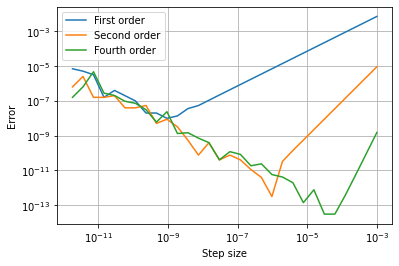

In [7]:
L_0 = 2*np.pi
iota_0 = 0.3

eta_bar = 2.00054591
x = pack_dofs(eta_bar, axis)


np.random.seed(0)
h = np.random.rand(x.shape[0])
h = h/np.linalg.norm(h)

j = J(x)
dj = dJ(x)
dj_exact = np.dot(h,dj)

error = np.zeros((4, 30))
eps_list = 0.5**np.array(range(10,40))
for i,order in enumerate([1, 2, 4]):
    if order == 1: # first order forward difference.
        shifts = [0, 1]
        weights = [-1, 1]
    elif order == 2: # second order central difference.
        shifts = [-1, 1]
        weights = [-0.5, 0.5]
    elif order == 4: # fourth order central difference.
        shifts = [-2, -1, 1, 2]
        weights = [1/12, -2/3, 2/3, -1/12]


    
    dj_fd = 0
    for ii in range(10, 40):
        eps = 0.5**ii
        
        dj_fd = 0
        for s,w in zip(shifts,weights):
            dj_fd = dj_fd + w*J(x+s*eps*h)
        dj_fd = dj_fd / eps
        error[i, ii-10] = np.abs( dj_fd - dj_exact )

%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
for ii in range(3):
    plt.loglog(eps_list, error[ii,:])
plt.grid()
plt.xlabel('Step size')
plt.ylabel('Error')
plt.legend(['First order', 'Second order', 'Fourth order'])

# Solve the optimization problem

Now that we have verified that the gradient is correctly implemented, let's solve the optimization problem.  That is, let's find an axis with length $2\pi$ and a target rotational transform of $\iota_0 = 0.103$.

## Task 4
Comment on the value of the objective function and the norm of the gradient.

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


0.0052056575542863935 0.03362355469121434


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


2.0655905023301183e-13 2.536288139715067e-06


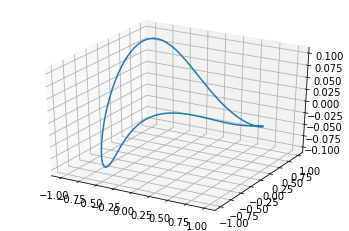

In [8]:
from scipy.optimize import minimize
def scipy_fun(x):
    res = J(x)
    dres = dJ(x)    
    return res, dres

L_0 = 2*np.pi
iota_0 = 0.1

x = pack_dofs(eta_bar, axis)

j,dj = scipy_fun(x)

print(j,np.linalg.norm(dj))
res = minimize(scipy_fun, x, jac=True, method='bfgs', tol=1e-10)
j,dj = scipy_fun(res.x)
print(j,np.linalg.norm(dj))

axis.set_dofs(res.x[1::])
axis.plot()